In [1]:
import os
import re
import sys
import glob
import time
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

import math
from scipy          import stats
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import matplotlib

# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.rcParams["figure.figsize"] = 7.5, 4.5
plt.rcParams["font.size"]      = 12

In [6]:
fav_col = '#418094'

In [7]:
filename = '/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-11_25_2024-file.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

## Use channel 1 and 4 as veto (they have foils that only accept visible light)

In [8]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/'
all_chs   = range(13)

thr_ADC        = 80
sg_filt_window = 30
min_dist       = 50

def extract_date_obj_and_number(filename):
    match       = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    date_str    = match.group(1)
    file_number = int(match.group(2))
    date_obj    = datetime.strptime(date_str, "%m_%d_%Y")
    return date_obj, file_number

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

def adapt_evt_id(evt_id, fnum):
    return 1000000*fnum + np.array(evt_id)

filt_files   = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_run-*')
sorted_files = sorted(filt_files, key=extract_date_obj_and_number)

In [9]:
### Gains to calibrate the channels
## With the trigger channels it depends on the date because there were more variations

gains_all_chs = {0: (142.951, 5.925),
                 1: (132.500, -3.333),
                 2: (135.502, 12.886),
                 3: (135.000, -5.000),
                 4: (143.315,  5.262),
                 5: (137.660, 11.814),
                 6: (130.000, 0.),
                 7: (138.123, 12.840),
                 8: (131.772, 13.920),
                 9: {'09_10_2024': (713.445, -20.038), 
                     '09_11_2024': (716.176, -19.673), 
                     '09_12_2024': (719.783, -10.151), 
                     '09_20_2024': (722.221, -11.124), 
                     '09_25_2024': (723.042, -11.830), 
                     '09_28_2024': (721.611, -12.276), 
                     '10_04_2024': (720.181, -12.722), 
                     '10_11_2024': (725.152, -12.032), 
                     '10_17_2024': (728.640, -11.851), 
                     '10_25_2024': (722.907, -12.550), 
                     '11_01_2024': (724.566, -11.215), 
                     '11_11_2024': (714.408, -12.857), 
                     '11_25_2024': (704.251, -14.499), 
                     '12_13_2024': (691.857,   2.794), 
                     '12_21_2024': (680.420,  -3.534), 
                     '01_02_2025': (671.088,   4.511), 
                     '01_10_2025': (703.052,   0.083), 
                     '01_19_2025': (707.833,  -5.059)},
                 
                 10: {'09_10_2024': (707.800, 43.580), 
                      '09_11_2024': (707.968, 44.407), 
                      '09_12_2024': (706.610, 45.092), 
                      '09_20_2024': (703.655, 53.165), 
                      '09_25_2024': (703.754, 53.722), 
                      '09_28_2024': (704.139, 52.949), 
                      '10_04_2024': (705.643, 52.823), 
                      '10_11_2024': (706.706, 53.208), 
                      '10_17_2024': (707.740, 53.039), 
                      '10_25_2024': (707.276, 53.987), 
                      '11_01_2024': (705.825, 54.078), 
                      '11_11_2024': (705.377, 53.354), 
                      '11_25_2024': (705.761, 52.763), 
                      '12_13_2024': (709.026, 53.851), 
                      '12_21_2024': (709.094, 55.053), 
                      '01_02_2025': (709.721, 55.118), 
                      '01_10_2025': (710.348, 55.183), 
                      '01_19_2025': (711.481, 54.422)},
                 
                 11: {'09_10_2024': (641.030, 48.974), 
                      '09_11_2024': (642.714, 47.617), 
                      '09_12_2024': (645.527, 48.325), 
                      '09_20_2024': (648.580, 45.411), 
                      '09_25_2024': (651.633, 42.497), 
                      '09_28_2024': (651.651, 42.437), 
                      '10_04_2024': (652.104, 42.815), 
                      '10_11_2024': (652.307, 42.757), 
                      '10_17_2024': (652.510, 42.698), 
                      '10_25_2024': (641.258, 60.174), 
                      '11_01_2024': (647.961, 51.403), 
                      '11_11_2024': (654.665, 42.632), 
                      '11_25_2024': (656.109, 43.477), 
                      '12_13_2024': (656.052, 44.115), 
                      '12_21_2024': (655.995, 44.754), 
                      '01_02_2025': (655.938, 45.393), 
                      '01_10_2025': (655.881, 46.032), 
                      '01_19_2025': (656.365, 44.774)}}

In [10]:
filt_files   = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_run-*')
sorted_files = sorted(filt_files, key=extract_date_obj_and_number)

### Channel1 coincidence events

In [42]:
normal_chs = range(9)
start_time = time.time()

idx_thr_pv_coinc1     = {} # Events coincident with channel 1
idx_max_pv_coinc1     = {}
height_sg_d_pv_coinc1 = {}
num_evts_pv_coinc1    = {}
idx_thr_pv_no_coinc1     = {} # Events non coincident with channel 1
idx_max_pv_no_coinc1     = {}
height_sg_d_pv_no_coinc1 = {}
num_evts_pv_no_coinc1    = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    evts_ch1 = d['filt_evts_dict'].item()[1]

    for ch in normal_chs:
        idx_thr_after_cut  = []
        idx_max_after_cut  = []
        height_after_cut   = []
        idx_thr_after_cut2 = []
        idx_max_after_cut2 = []
        height_after_cut2  = []
        num_evts           = 0
        num_evts2          = 0
        filt_evts_num      = d['filt_evts_dict']        .item()[ch]
        idx_peaks_thr_ch   = d['idx_peaks_thr']         .item()[ch]
        idx_peaks_max_ch   = d['idx_peaks_max']         .item()[ch]
        height_peaks_ch    = d['height_peaks_sg_deconv'].item()[ch]
        
        for evt_n, idxs, idxs2, vals in zip(filt_evts_num, idx_peaks_thr_ch, idx_peaks_max_ch, height_peaks_ch):
            if len(idxs)==0:
                continue
            if evt_n not in evts_ch1:
                idx_thr_after_cut2.append(idxs)
                idx_max_after_cut2.append(idxs2)
                height_after_cut2 .append(vals)
                num_evts2 += 1
                continue
            idx_thr_after_cut.append(idxs)
            idx_max_after_cut.append(idxs2)
            height_after_cut .append(vals)
            num_evts += 1
                
        if date not in idx_thr_pv_coinc1:
            print(date)
            idx_thr_pv_coinc1    [date] = {}
            idx_max_pv_coinc1    [date] = {}
            height_sg_d_pv_coinc1[date] = {}
            num_evts_pv_coinc1   [date] = {}
        else:

            if ch not in idx_thr_pv_coinc1[date]:
                try:
                    idx_thr_pv_coinc1    [date][ch] = np.concatenate(idx_thr_after_cut)
                    idx_max_pv_coinc1    [date][ch] = np.concatenate(idx_max_after_cut)
                    height_sg_d_pv_coinc1[date][ch] = np.concatenate(height_after_cut)
                    num_evts_pv_coinc1   [date][ch] = np.array([num_evts])
                except Exception as e:
                    print(e)
                    continue
            else:
                try:
                    idx_thr_pv_coinc1    [date][ch] = np.concatenate((idx_thr_pv_coinc1    [date][ch], np.concatenate(idx_thr_after_cut)))
                    idx_max_pv_coinc1    [date][ch] = np.concatenate((idx_max_pv_coinc1    [date][ch], np.concatenate(idx_max_after_cut)))
                    height_sg_d_pv_coinc1[date][ch] = np.concatenate((height_sg_d_pv_coinc1[date][ch], np.concatenate(height_after_cut)))
                    num_evts_pv_coinc1   [date][ch] = np.concatenate((num_evts_pv_coinc1   [date][ch], np.array([num_evts])))
                except Exception as e:
                    print(e)
                    continue

        if date not in idx_thr_pv_no_coinc1:
            print(date)
            idx_thr_pv_no_coinc1    [date] = {}
            idx_max_pv_no_coinc1    [date] = {}
            height_sg_d_pv_no_coinc1[date] = {}
            num_evts_pv_no_coinc1   [date] = {}
        else:

            if ch==1:
                continue
            if ch not in idx_thr_pv_no_coinc1[date]:
                try:
                    idx_thr_pv_no_coinc1    [date][ch] = np.concatenate(idx_thr_after_cut2)
                    idx_max_pv_no_coinc1    [date][ch] = np.concatenate(idx_max_after_cut2)
                    height_sg_d_pv_no_coinc1[date][ch] = np.concatenate(height_after_cut2)
                    num_evts_pv_no_coinc1   [date][ch] = np.array([num_evts2])
                except Exception as e:
                    print(e)
                    continue
            else:
                try:
                    idx_thr_pv_no_coinc1    [date][ch] = np.concatenate((idx_thr_pv_no_coinc1    [date][ch], np.concatenate(idx_thr_after_cut2)))
                    idx_max_pv_no_coinc1    [date][ch] = np.concatenate((idx_max_pv_no_coinc1    [date][ch], np.concatenate(idx_max_after_cut2)))
                    height_sg_d_pv_no_coinc1[date][ch] = np.concatenate((height_sg_d_pv_no_coinc1[date][ch], np.concatenate(height_after_cut2)))
                    num_evts_pv_no_coinc1   [date][ch] = np.concatenate((num_evts_pv_no_coinc1   [date][ch], np.array([num_evts2])))
                except Exception as e:
                    print(e)
                    continue
        

end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1380
0
09_10_2024
09_10_2024
09_11_2024
09_11_2024
20
40
09_12_2024
09_12_2024
60
09_20_2024
09_20_2024
80
100
120
140
160
09_25_2024
09_25_2024
180
200
220
09_28_2024
09_28_2024
240
260
280
10_04_2024
10_04_2024
300
320
340
360
10_11_2024
10_11_2024
380
400
420
440
460
10_17_2024
10_17_2024
480
500
520
540
560
10_25_2024
10_25_2024
580
600
620
640
11_01_2024
11_01_2024
660
680
700
720
11_11_2024
11_11_2024
740
760
780
800
820
11_25_2024
11_25_2024
840
860
880
900
920
12_13_2024
12_13_2024
940
960
980
1000
1020
12_21_2024
12_21_2024
1040
1060
1080
1100
01_02_2025
01_02_2025
1120
1140
1160
1180
1200
01_10_2025
01_10_2025
1220
1240
1260
1280
01_19_2025
01_19_2025
1300
1320
1340
1360
Elapsed time: 429.0925130844116 s, 7.151541884740194 min


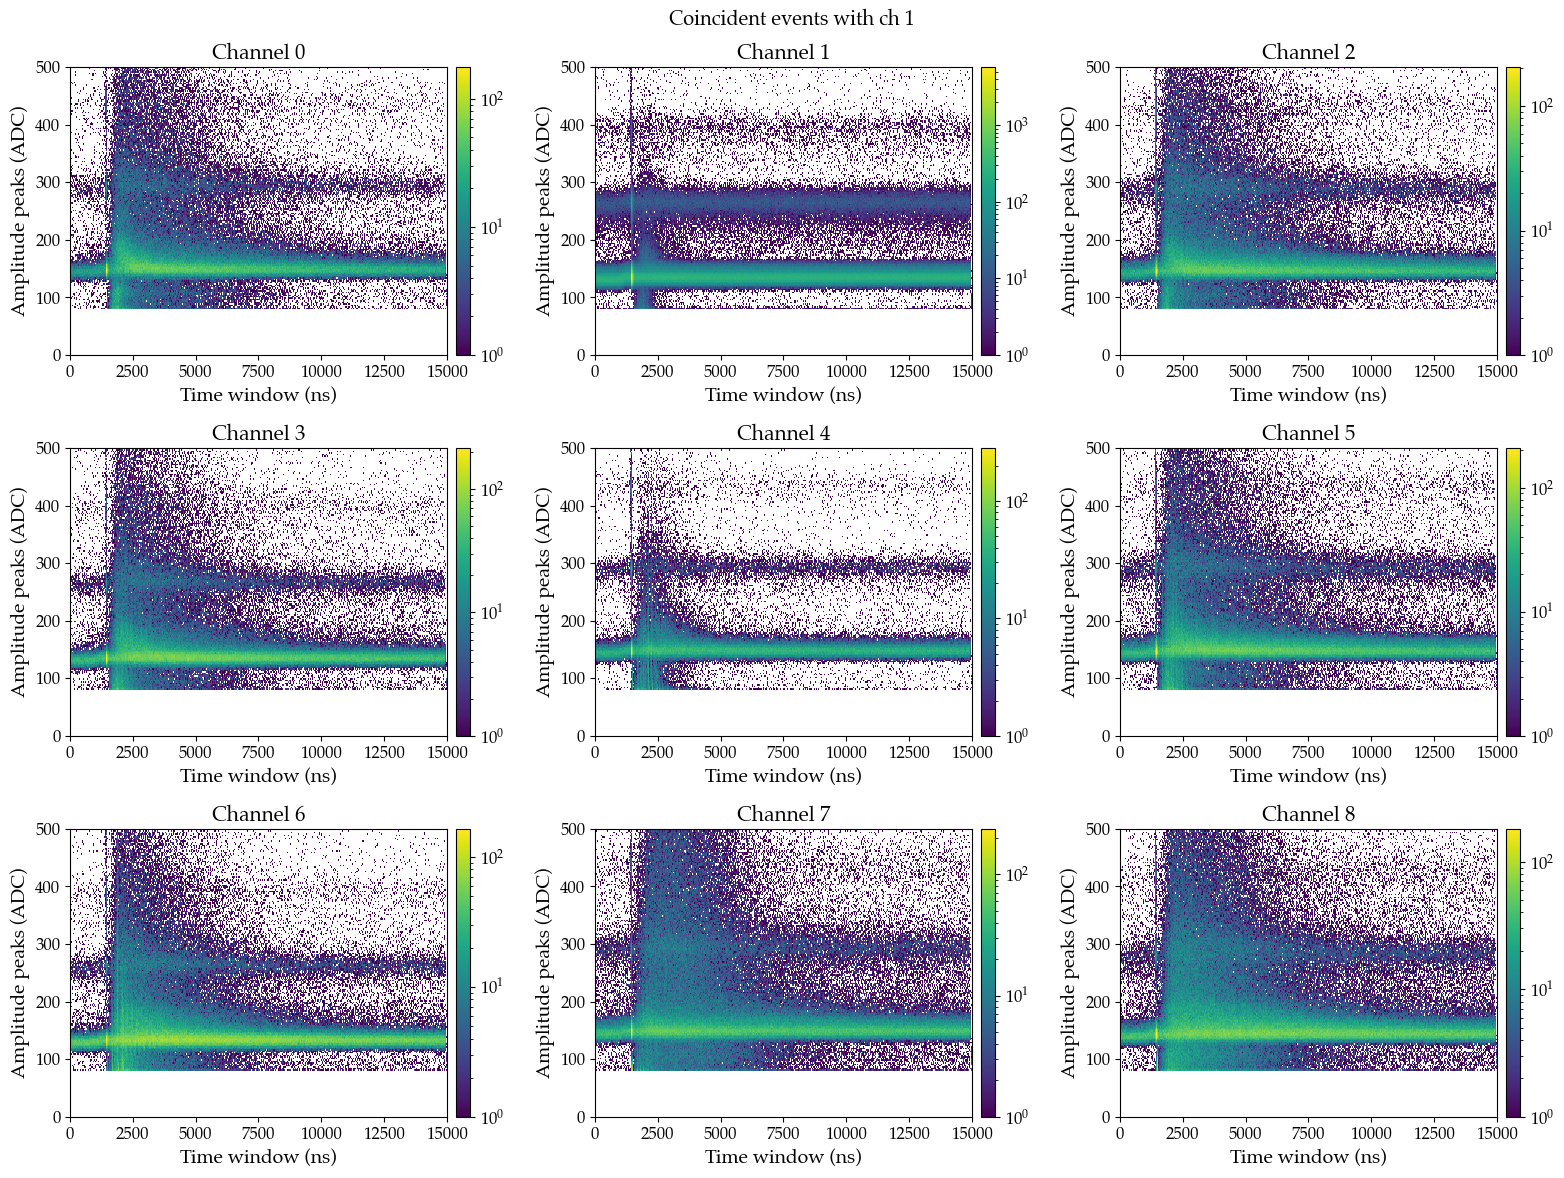

In [53]:
sel_dates = idx_thr_pv_coinc1.keys()
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
    
    try:
        ch_idxs = np.concatenate([idx_thr_pv_coinc1    [date][ch] for date in sel_dates])
        ch_vals = np.concatenate([height_sg_d_pv_coinc1[date][ch] for date in sel_dates])
    
        fig0 = axs[i][j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 500)), cmin=1, norm=LogNorm())
        axs[i][j].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i][j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i][j].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i][j], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.suptitle('Coincident events with ch 1')
plt.tight_layout()
#plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/hit_maps_pretrigg_and_high_light.pdf', bbox_inches='tight')
plt.show()

1


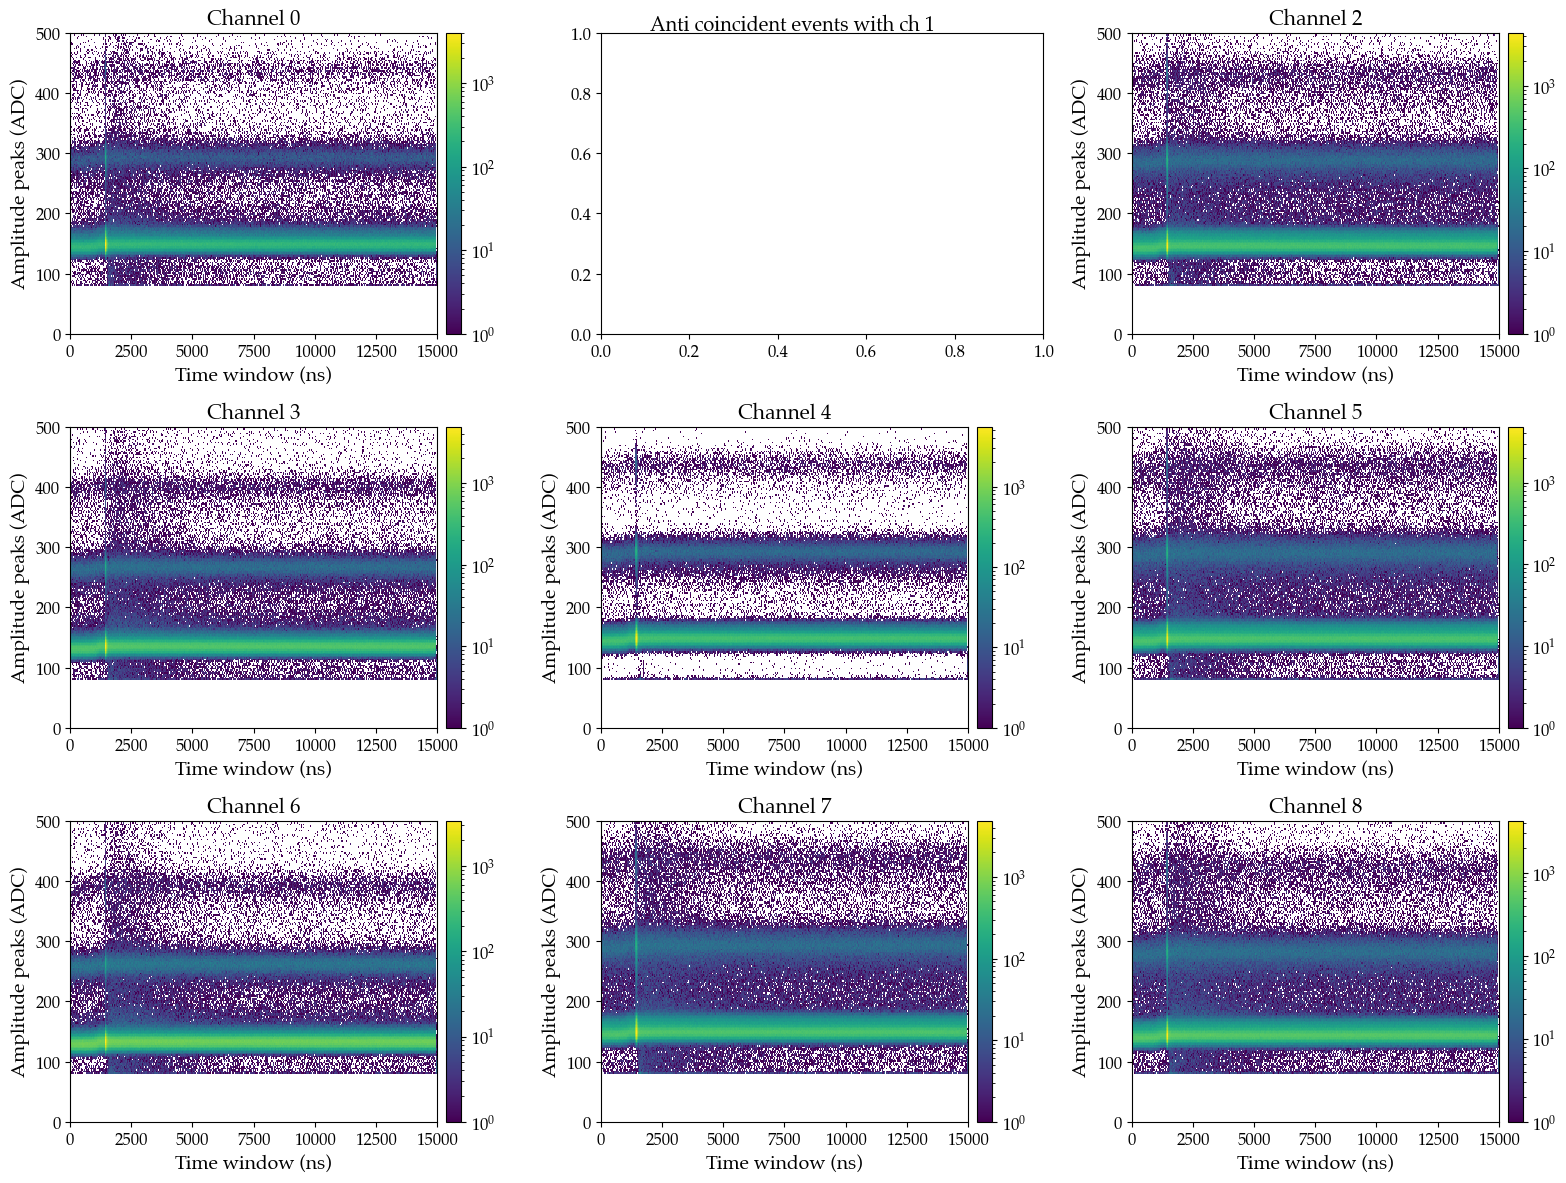

In [44]:
sel_dates = idx_thr_pv_coinc1.keys()
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
    
    try:
        ch_idxs = np.concatenate([idx_thr_pv_no_coinc1    [date][ch] for date in sel_dates])
        ch_vals = np.concatenate([height_sg_d_pv_no_coinc1[date][ch] for date in sel_dates])
    
        fig0 = axs[i][j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 500)), cmin=1, norm=LogNorm())
        axs[i][j].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i][j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i][j].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i][j], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
plt.suptitle('Anti coincident events with ch 1')
#plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/hit_maps_pretrigg_and_high_light.pdf', bbox_inches='tight')
plt.show()

6
3
0


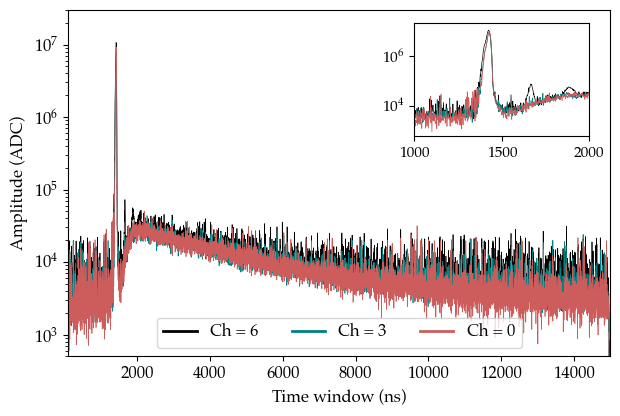

7
4
1


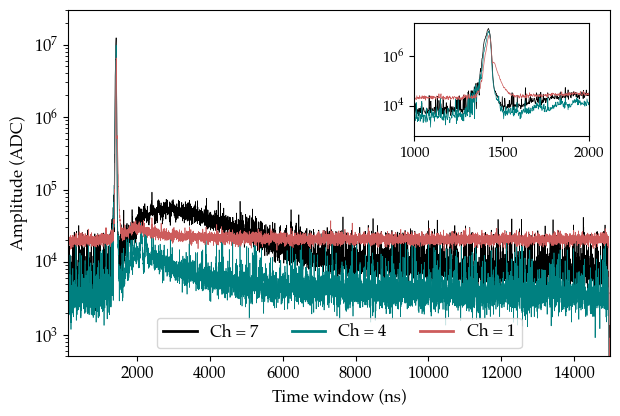

8
5
2


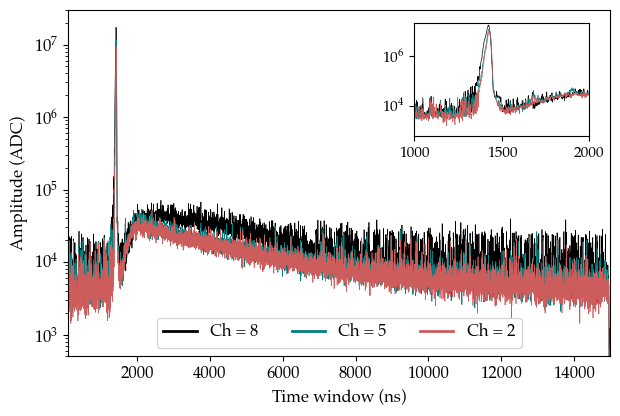

In [49]:
sel_dates = idx_thr_pv_coinc1.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        print(ch)
        timestamps = 2*np.concatenate([idx_thr_pv_coinc1    [date][ch] for date in sel_dates])
        amplitudes =   np.concatenate([height_sg_d_pv_coinc1[date][ch] for date in sel_dates])
        
        unique_timestamps = np.unique(timestamps)
        sum_amplitudes    = [np.sum(amplitudes[timestamps == timestamp]) for timestamp in unique_timestamps]
    
        plt.plot(unique_timestamps, sum_amplitudes, lw=0.5, c=col, label=f'Ch = {ch}')
        

    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',   fontsize=12)
    plt.yscale('log')
    plt.xlim(100, 15000)
    plt.ylim(5e2, 3e7)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)
        
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        timestamps = 2*np.concatenate([idx_thr_pv_coinc1    [date][ch] for date in sel_dates])
        amplitudes =   np.concatenate([height_sg_d_pv_coinc1[date][ch] for date in sel_dates])
        unique_timestamps = np.unique(timestamps)
        sum_amplitudes    = [np.sum(amplitudes[timestamps == timestamp]) for timestamp in unique_timestamps]
        ax_inset.plot(unique_timestamps, sum_amplitudes, c=col, lw=0.5)
        
        
    ax_inset.set_xlim(1000, 2000)
    ax_inset.set_ylim(6e2, 2e7)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    #plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/t_dist_pretrigg_and_high_light_chs_{sel_chs[0]}_{sel_chs[1]}_{sel_chs[2]}.pdf', bbox_inches='tight')
    plt.show()

6
3
0


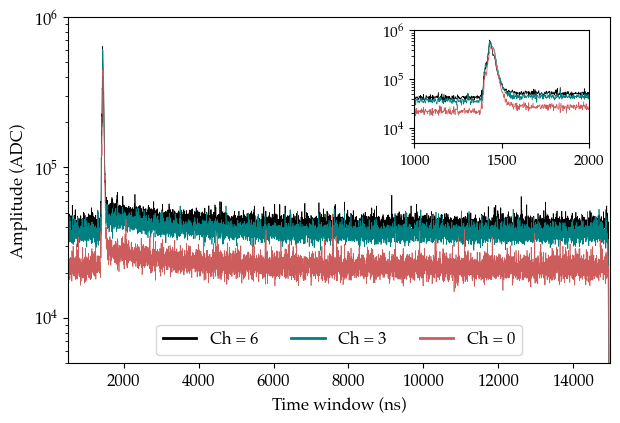

7
4
1


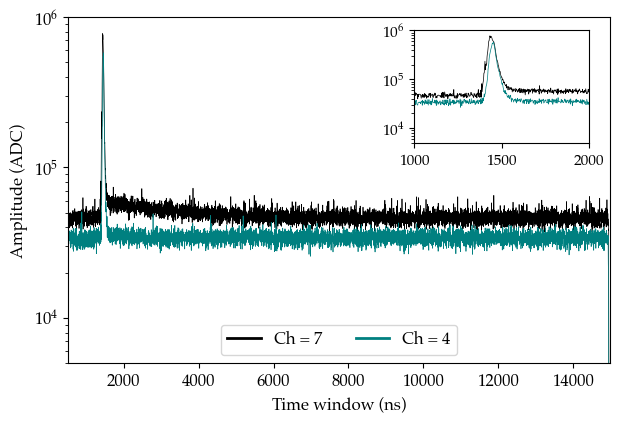

8
5
2


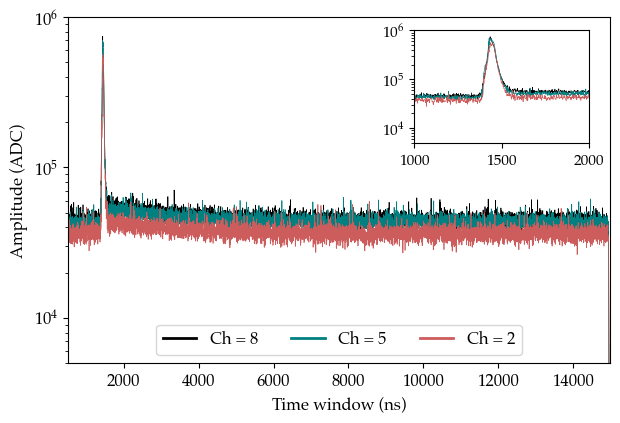

In [52]:
sel_dates = idx_thr_pv_no_coinc1.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        print(ch)
        if ch==1:
            continue
        timestamps = 2*np.concatenate([idx_thr_pv_no_coinc1    [date][ch] for date in sel_dates])
        amplitudes =   np.concatenate([height_sg_d_pv_no_coinc1[date][ch] for date in sel_dates])
        
        unique_timestamps = np.unique(timestamps)
        sum_amplitudes    = [np.sum(amplitudes[timestamps == timestamp]) for timestamp in unique_timestamps]
    
        plt.plot(unique_timestamps, sum_amplitudes, lw=0.5, c=col, label=f'Ch = {ch}')
        

    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',   fontsize=12)
    plt.yscale('log')
    plt.xlim(500, 15000)
    plt.ylim(5e3, 1e6)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)
        
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        if ch==1:
            continue
        timestamps = 2*np.concatenate([idx_thr_pv_no_coinc1    [date][ch] for date in sel_dates])
        amplitudes =   np.concatenate([height_sg_d_pv_no_coinc1[date][ch] for date in sel_dates])
        unique_timestamps = np.unique(timestamps)
        sum_amplitudes    = [np.sum(amplitudes[timestamps == timestamp]) for timestamp in unique_timestamps]
        ax_inset.plot(unique_timestamps, sum_amplitudes, c=col, lw=0.5)
        
        
    ax_inset.set_xlim(1000, 2000)
    ax_inset.set_ylim(5e3, 1e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    #plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/t_dist_pretrigg_and_high_light_chs_{sel_chs[0]}_{sel_chs[1]}_{sel_chs[2]}.pdf', bbox_inches='tight')
    plt.show()